In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, pyll
from hyperopt.pyll.base import scope

%matplotlib inline

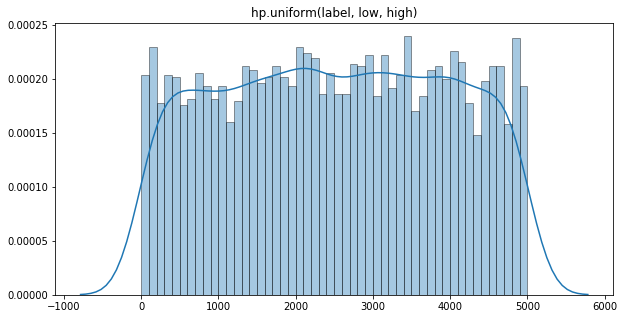

In [2]:
space1 = [pyll.stochastic.sample(hp.uniform('x', 0, 5000)) for _ in range(5000)]

plt.figure(figsize=(10, 5))
sns.distplot(space1, bins=50, hist_kws={'edgecolor':'k'})
plt.title("hp.uniform(label, low, high)")
plt.show()

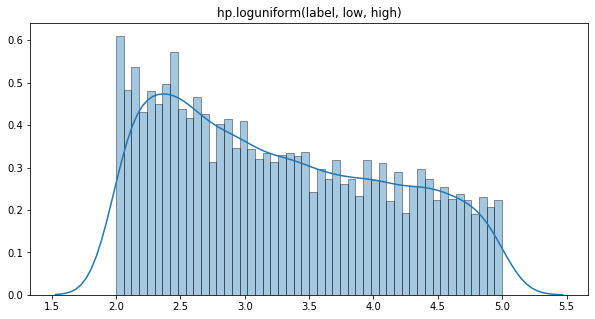

In [3]:
space2 = [pyll.stochastic.sample(hp.loguniform('x', np.log(2), np.log(5))) for _ in range(5000)]

plt.figure(figsize=(10, 5))
sns.distplot(space2, bins=50, hist_kws={'edgecolor':'k'})
plt.title("hp.loguniform(label, low, high)")
plt.show()

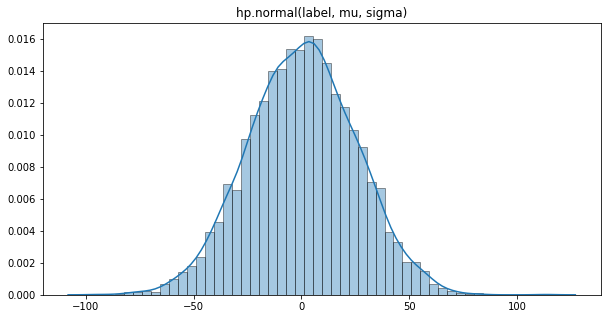

In [4]:
space3 = [pyll.stochastic.sample(hp.normal('x', 0, 25)) for _ in range(5000)]

plt.figure(figsize=(10, 5))
sns.distplot(space3, bins=50, hist_kws={'edgecolor':'k'})
plt.title("hp.normal(label, mu, sigma)")
plt.show()

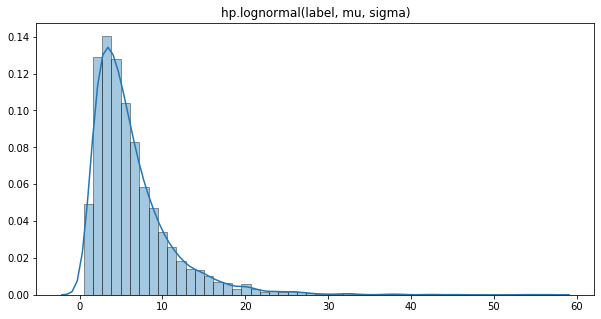

In [5]:
space4 = [pyll.stochastic.sample(hp.lognormal('x', np.log(5), np.log(2))) for _ in range(5000)]

plt.figure(figsize=(10, 5))
sns.distplot(space4, bins=50, hist_kws={'edgecolor':'k'})
plt.title("hp.lognormal(label, mu, sigma)")
plt.show()

In [8]:
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from pprint import pprint

X, y = make_regression(n_samples=100, n_features=20, n_informative=4, bias=50.0, noise=50.0)

cv = KFold(n_splits=5)

search_space = {
    'scaler': hp.choice('scaler', [StandardScaler(), MinMaxScaler(), RobustScaler()]),
    
    'reducer': hp.choice('reducer', [SelectKBest(f_regression), PCA()]),
    'reducer__k': scope.int(hp.quniform('reducer__k', 2, X.shape[1], 1)),
    'reducer__n_components': scope.int(hp.quniform('reducer__n_components', 2, X.shape[1], 1)),
    
    'estimator__n_neurons': scope.int(hp.quniform('estimator__n_neurons', 5, 50, 1)),
    'estimator__n_layers': scope.int(hp.quniform('estimator__n_layers', 1, 5, 1)),
    'estimator__activation': hp.choice('estimator__activation', ['logistic', 'tanh', 'relu']),
    'estimator__solver': hp.choice('estimator__solver', ['lbfgs', 'sgd', 'adam']),
    'estimator__alpha': hp.qloguniform('estimator__alpha', np.log(1e-4), np.log(10), 1e-3),
    'estimator__learning_rate' : hp.choice('estimator__learning_rate', ['constant', 'invscaling', 'adaptive']),
    'estimator__max_iter' : scope.int(hp.quniform('estimator__max_iter', 20, 500, 20)),
    'estimator__momentum': hp.quniform('estimator__momentum', 0, 1, 0.01),
    'estimator__early_stopping': hp.choice('estimator__early_stopping', [True, False]),
    'estimator__beta_1': hp.quniform('estimator__beta_1', 0, 0.999, 1e-3),
    'estimator__beta_2': hp.quniform('estimator__beta_2', 0, 0.999, 1e-3)
}

def build_model(p):
    '''
    return a model with hyperparameters
    '''
    model = MLPRegressor(
        hidden_layer_sizes=tuple([p['estimator__n_neurons'] for _ in range(p['estimator__n_layers'])]),
        activation=p['estimator__activation'],
        solver=p['estimator__solver'],
        alpha=p['estimator__alpha'],
        learning_rate=p['estimator__learning_rate'],
        max_iter=p['estimator__max_iter'],
        momentum=p['estimator__momentum'],
        early_stopping=p['estimator__early_stopping'],
        beta_1=p['estimator__beta_1'],
        beta_2=p['estimator__beta_2']
    )
    return model

def calculate_loss(model, X, y):
    '''
    return a score value to MINIMIZE (if R2 then negate it)
    '''
    scores = cross_val_score(estimator=model, X=X, y=y, scoring='r2', cv=cv, n_jobs=4, verbose=0)
    return -scores.mean()

def f_objective(p):
    try:
        pipe = Pipeline([
            ('scaler', p['scaler']),
            ('reducer', p['reducer']),
            ('estimator', build_model(p))
        ])
        
        try: pipe.set_params(**{'reducer__k':p['reducer__k']})
        except: pass
        try: pipe.set_params(**{'reducer__n_components':p['reducer__n_components']})
        except: pass
        
        loss = calculate_loss(pipe, X, y)
        return { 'loss': loss, 'status': STATUS_OK }
    except Exception as e:
        print(e)
        return { 'loss': np.Inf, 'status': STATUS_FAIL }

trials = Trials()

best = fmin(fn=f_objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=100,
            show_progressbar=True,
            trials=trials)

print("The best hyperparameters:")
pprint(space_eval(search_space, best))

Input contains NaN, infinity or a value too large for dtype('float64').        
Input contains NaN, infinity or a value too large for dtype('float64').         
Input contains NaN, infinity or a value too large for dtype('float64').         
100%|██████████| 100/100 [04:18<00:00,  2.58s/it, best loss: -0.8195589054932769]
The best hyperparameters:
{'estimator__activation': 'relu',
 'estimator__alpha': 0.089,
 'estimator__beta_1': 0.243,
 'estimator__beta_2': 0.10300000000000001,
 'estimator__early_stopping': True,
 'estimator__learning_rate': 'constant',
 'estimator__max_iter': 280,
 'estimator__momentum': 0.5,
 'estimator__n_layers': 1,
 'estimator__n_neurons': 18,
 'estimator__solver': 'sgd',
 'reducer': SelectKBest(k=8, score_func=<function f_regression at 0x12258a730>),
 'reducer__k': 8,
 'reducer__n_components': 15,
 'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)}


## visualize trials objects

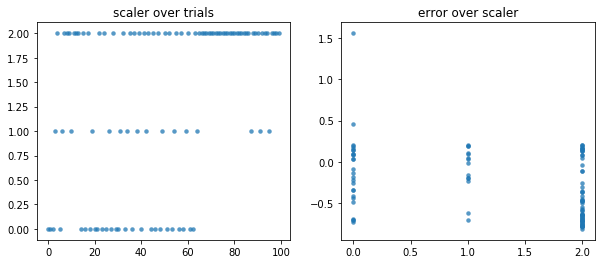

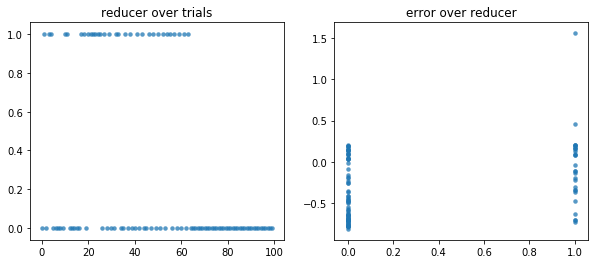

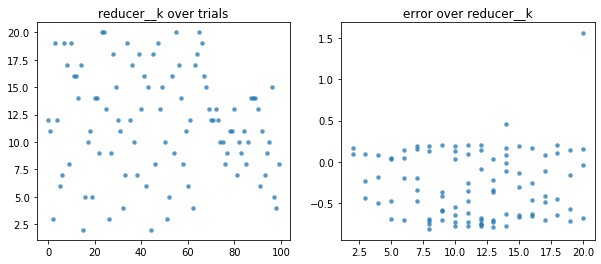

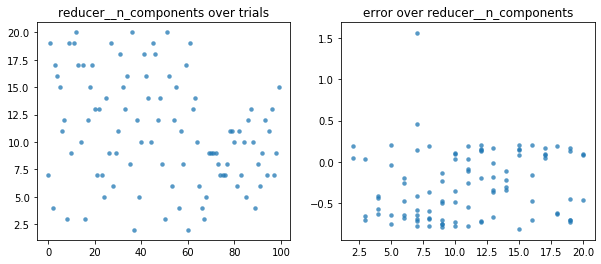

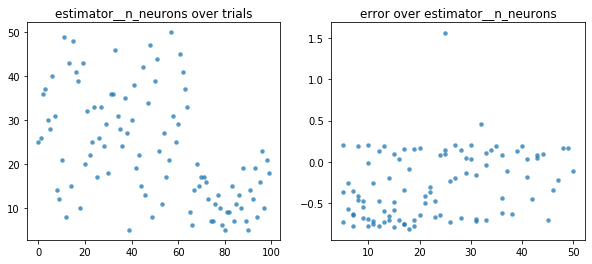

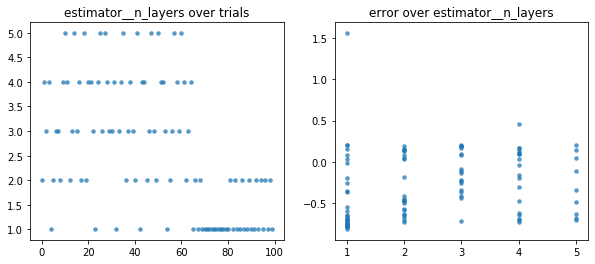

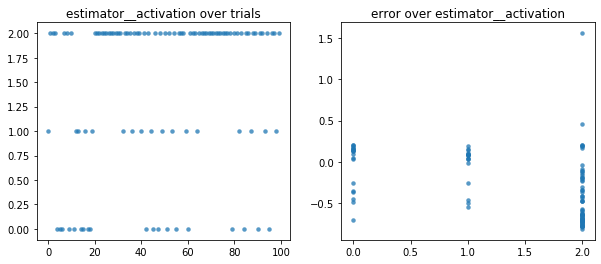

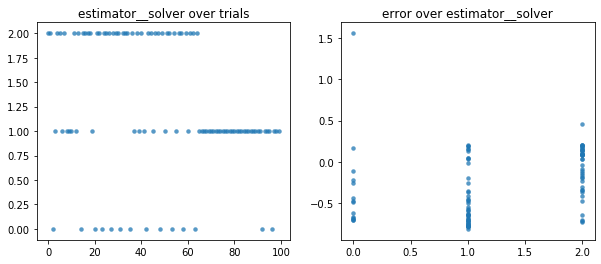

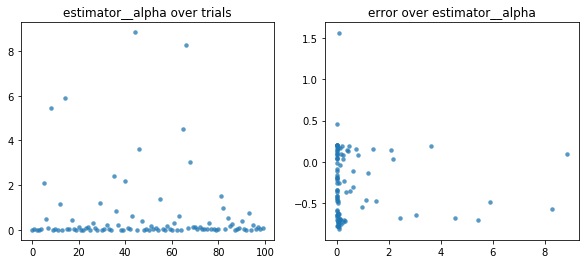

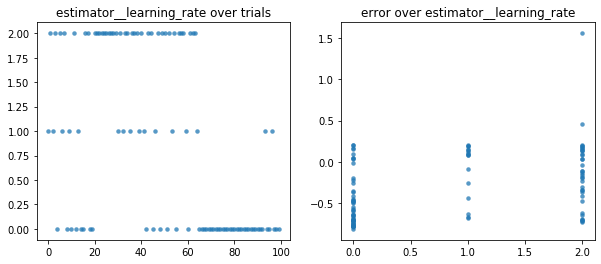

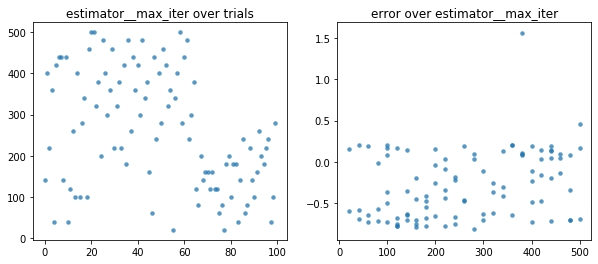

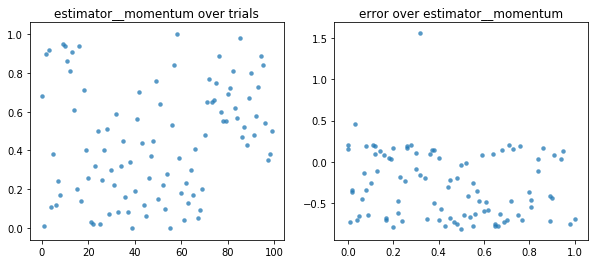

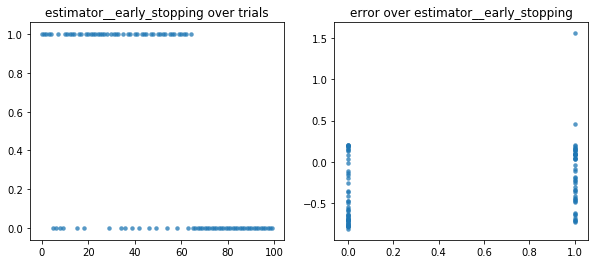

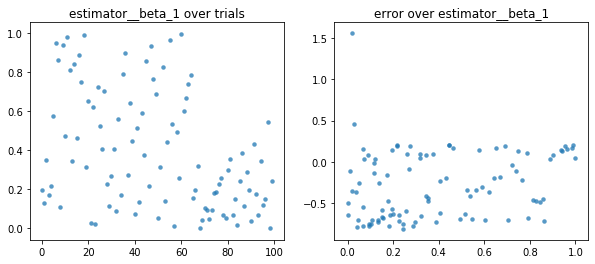

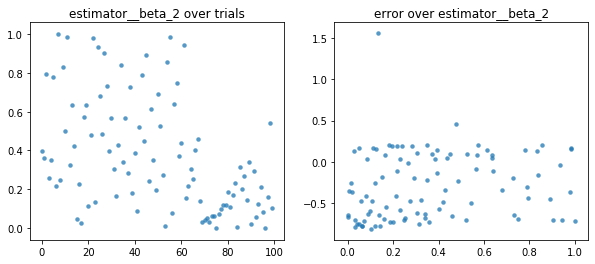

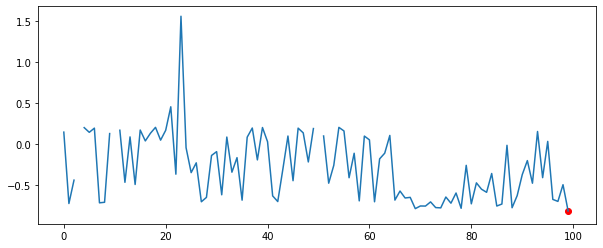

In [9]:
import pandas as pd
trials_df = pd.DataFrame(columns=search_space.keys())
for i, trial in enumerate(trials.trials):
    trials_df.loc[i, 'error'] = trial['result']['loss']
    
for i, trial in enumerate(trials.trials):
    for k in trial['misc']['vals'].keys():
        trials_df.loc[i, k] = trial['misc']['vals'][k][0]

for i,c in enumerate(trials_df.drop(['error'],1).columns):
    fig, ax = plt.subplots(1,2, figsize=(10, 4))
    ax[0].scatter(trials_df.index, trials_df[c], s=20, linewidth=0.01, alpha=0.75)
    ax[1].scatter(trials_df[c], trials_df['error'], s=20, linewidth=0.01, alpha=0.75)
    ax[0].set_title(f'{c} over trials')
    ax[1].set_title(f'error over {c}')
    plt.show()

trial_seq = []
err_seq = []
for trial in trials.trials:
    trial_seq.append(trial['tid'])
    err_seq.append(trial['result']['loss'])
plt.figure(figsize=(10,4))
plt.plot(trial_seq, err_seq)
plt.scatter(np.argmin(err_seq), min(err_seq), c='r')
plt.show()